In [5]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import os, json, joblib
from dotenv import load_dotenv
from sqlalchemy import create_engine, text
from sqlalchemy.engine import URL
from pathlib import Path
import unicodedata as ud
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

### Conectando com o Banco de Dados

In [7]:
load_dotenv()

HOST = os.getenv("PGHOST")
PORT = os.getenv("PGPORT")
DB   = os.getenv("PGDATABASE")
USR  = os.getenv("PGUSER")
PWD  = os.getenv("PGPASSWORD")

In [8]:
# 1) Caminho .env local
ENV_PATH = Path(r"C:\Users\cicer\Documents\Case Técnico Paipe\Análise Exploratória\.env")
print("Arquivo .env existe?", ENV_PATH.exists(), "\nCaminho:", ENV_PATH)

# 2) Carrega o .env
load_dotenv(dotenv_path=ENV_PATH, override=True)

# 3) Confere o que foi lido
cfg = {k: os.getenv(k) for k in ["PGHOST", "PGPORT", "PGDATABASE", "PGUSER"]}
print(cfg, "| PGPASSWORD set?", bool(os.getenv("PGPASSWORD")))


Arquivo .env existe? True 
Caminho: C:\Users\cicer\Documents\Case Técnico Paipe\Análise Exploratória\.env
{'PGHOST': 'localhost', 'PGPORT': '5432', 'PGDATABASE': 'PaipeTech', 'PGUSER': 'postgres'} | PGPASSWORD set? True


In [9]:
HOST = os.getenv("PGHOST", "localhost")
PORT = int(os.getenv("PGPORT") or 5432)
DB   = os.getenv("PGDATABASE")
USR  = os.getenv("PGUSER")
PWD  = os.getenv("PGPASSWORD")

url = URL.create(
    "postgresql+psycopg2",
    username=USR,
    password=PWD,   
    host=HOST,
    port=PORT,
    database=DB,
)

engine = create_engine(url, pool_pre_ping=True)

# teste rápido
with engine.begin() as conn:
    print("DB atual:", conn.execute(text("SELECT current_database()")).scalar())
    print("Versão:",  conn.execute(text("SELECT version()")).scalar().splitlines()[0])


DB atual: PaipeTech
Versão: PostgreSQL 18.0 on x86_64-windows, compiled by msvc-19.44.35215, 64-bit


In [10]:
df = pd.read_sql(text("SELECT * FROM public.teste"), engine)

In [11]:
SEED = 42

df_test = df 

# Padroniza nomes
df_test_raw = df_test.copy()
df_test_raw.columns = [c.lower() for c in df_test_raw.columns]

try:
    BASE = '.' 
    base_candidates = [Path(BASE)]
except NameError:
    base_candidates = [Path("."), Path("./models_lgbm_corrigido"), Path("./models_lgbm")]

meta_path = model_path = None
for d in base_candidates:
    if (d / "inference_meta.json").exists() and meta_path is None:
        meta_path = d / "inference_meta.json"
    if (d / "lgbm_model_final.pkl").exists() and model_path is None:
        model_path = d / "lgbm_model_final.pkl"

if meta_path is None or model_path is None:
    raise FileNotFoundError(
        f"Não encontrei 'inference_meta.json' ou 'lgbm_model_final.pkl' em {base_candidates}. "
        "Ajuste os caminhos conforme onde você salvou os artefatos."
    )

with open(meta_path, "r", encoding="utf-8") as f:
    meta = json.load(f)
X_COLS     = meta["X_cols"]
CAT_LEVELS = meta["categorical_levels"]

#  Pré-processamento 
def build_features_infer(df: pd.DataFrame, X_COLS, CAT_LEVELS) -> pd.DataFrame:
    df = df.copy()

    # tempo médio até estação
    base_time = pd.to_numeric(df.get("timetoneareststation"), errors="coerce")
    min_t = pd.to_numeric(df.get("mintimetoneareststation"), errors="coerce")
    max_t = pd.to_numeric(df.get("maxtimetoneareststation"), errors="coerce")
    time_mean = base_time.copy() if isinstance(base_time, pd.Series) else pd.Series(np.nan, index=df.index)
    mask_nan = time_mean.isna()
    time_mean.loc[mask_nan] = (min_t[mask_nan] + max_t[mask_nan]) / 2.0
    df["time_to_station_mean"] = time_mean

    # logs 
    for src, dst in [
        ("totalfloorarea", "log_totalfloorarea"),
        ("area",           "log_area"),
        ("frontage",       "log_frontage"),
        ("breadth",        "log_breadth"),
    ]:
        if src in df.columns:
            df[dst] = np.log1p(pd.to_numeric(df[src], errors="coerce").fillna(0))

    # numéricos básicos
    for c in ["buildingyear","coverageratio","floorarearatio","year","quarter","municipalitycode"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # normalizar renovation
    if "renovation" in df.columns:
        df["renovation"] = (
            df["renovation"].astype(str).str.strip()
              .replace({"Yes":"Done","No":"Not yet","nan":"Not yet","NaN":"Not yet"})
        )

    # aplicar níveis categóricos fixos
    for c, levels in CAT_LEVELS.items():
        if c in df.columns:
            df[c] = pd.Categorical(df[c].astype(str), categories=levels)

    for c in X_COLS:
        if c not in df.columns:
            df[c] = np.nan

    return df

test_f = build_features_infer(df_test_raw, X_COLS, CAT_LEVELS)

X_te = test_f[X_COLS].copy()
for c in X_te.columns:
    if str(X_te[c].dtype) in ["object", "string"]:
        X_te[c] = X_te[c].astype("category")

#  Carregar o modelo salvo e prever 
model = joblib.load(str(model_path))

pred_log = model.predict(X_te)
pred = np.maximum(np.expm1(pred_log), 0)  # volta à escala original

#  Adiciona coluna 'previsoes' no DF original 
df_test_out = df_test_raw.copy()
df_test_out["previsoes"] = pred

# visualizar/salvar
print(df_test_out[["previsoes"]].head())
# df_test_out.to_csv("test_with_predictions.csv", index=False)


      previsoes
0  2.312421e+07
1  2.002220e+07
2  3.974290e+07
3  1.899952e+07
4  3.890357e+07


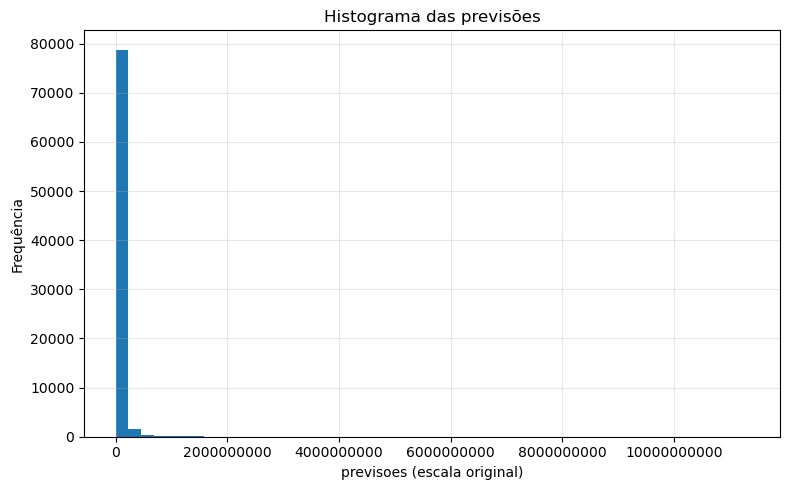

In [19]:
vals = pd.to_numeric(df_test_out["previsoes"], errors="coerce").dropna()

import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.hist(vals, bins=50)
plt.title("Histograma das previsões")
plt.xlabel("previsoes (escala original)")
plt.ylabel("Frequência")

ax = plt.gca()
ax.ticklabel_format(style="plain", useOffset=False, axis="x")  # <- sem 1e10 no eixo
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


**Justificando o uso do LightGBM: Modelo baseado em árvores e robusto. Tenho experiência prévia com ele, tem excelentes resultados e exige pouco pré processamento.** 
**Trata variáveis nulas, categóricas (evita ter que fazer OneHotEncoder e Label Encoder), além de não ser tão influenciável por outliers.** 
**Como não tinha muito tempo para desenvolver o modelo, escolhi ele por ser robusto e não necessitar de tantos pré processamentos.**